In this notebook we are going to compare a normal scikit NN regressor with its implementation on pytorch. Something is off so lets figure it out

Important, in scikit lern there is a extra for loop for batches!!!

In [2]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPRegressor
from torch.optim import Adam
import matplotlib.pyplot as plt
import cProfile

In [155]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from torch.utils.data import Dataset



class Net2layers(nn.Module):
    def __init__(self, input_size, l1_size, l2_size):
        super(Net2layers, self).__init__()
        self.fc1 = nn.Linear(input_size, l1_size)
        self.fc2 = nn.Linear(l1_size, l2_size)
        self.fc3 = nn.Linear(l2_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, df, feature_columns, device):
        m, n = df[feature_columns].shape
        x = torch.Tensor(df[feature_columns].values).to(device)
        output = self.forward(x)
        return output.detach().cpu().numpy()
    
def get_tensors(df, feature_columns, target_name, batch_size, device, shuffle):
    if shuffle:
        df = df.sample(frac=1).copy()
    m, n = df[feature_columns].shape
    x_all = torch.Tensor(df[feature_columns].values).to(device)
    y_all = torch.Tensor(df[target_name].values).to(device)
    x = x_all.reshape([-1, batch_size, n] )
    y = y_all.reshape([-1, batch_size, 1] )
    return x, y
    
def train_scikit(
    df_train,
    learning_rate,
    batch_size,
    n_iter,
    l1_size,
    l2_size,
    input_size,
    alpha,
    shuffle,
):
    model = MLPRegressor(
    hidden_layer_sizes=(l1_size,l2_size),
    random_state=1,
    verbose=False,
    shuffle=shuffle,
    max_iter=n_iter,
    tol=1e-14,
    alpha=alpha,
    learning_rate_init=learning_rate,
    batch_size=batch_size,
    n_iter_no_change=n_iter # we do not want early stop
    )
    
    model.fit(X=df_train[["x","y"]], y=df_train["target"])
    return model
    #return model.predict(df_train[["x", "y"]]), model
    

def train_pytorch(
    df_train,
    learning_rate,
    batch_size,
    n_iter,
    l1_size,
    l2_size,
    input_size,
    alpha,
    device,
    shuffle
):
    model = Net2layers(input_size=input_size, l1_size = l1_size, l2_size=l2_size).to(device)
    criterion = nn.MSELoss()
    optm = Adam(model.parameters(), lr = learning_rate, weight_decay=alpha)

    x, y = get_tensors(df_train,["x", "y"], "target", batch_size, device, shuffle=shuffle)

    for i in range(n_iter):
        for batch_id in range(x.size()[0]):

            optm.zero_grad()
            output = model(x[batch_id])
            loss = criterion(output,y[batch_id])
            loss.backward()
            optm.step()
    return model
    #return model.predict(df_train, ["x", "y"], device), model

In [104]:
print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(0))

0


In [180]:
# params
learning_rate=0.01
batch_size = 5000
n_iter = 100
sample_size = 5000
l1_size = 1000
l2_size = 100
input_size = 2
alpha = 0.0001
shuffle=True
cpu_dev = torch.device("cpu")
gpu_dev = torch.device('cuda:0')

In [181]:
df_train = pd.DataFrame(
    data={"x": np.linspace(1,10,sample_size),
          "y": np.linspace(1,10,sample_size), "target": np.linspace(1,10,sample_size)**3
         }).astype("float32")

In [172]:

#dataset = Dataset(df_train[["x", "y"]], df_train["target"])

In [182]:
%time  model_sklearn = train_scikit(df_train,learning_rate, batch_size,n_iter,l1_size,l2_size,input_size, alpha, shuffle)

CPU times: user 17 s, sys: 38.6 ms, total: 17 s
Wall time: 17 s


/Users/pablocanadapereira/opt/anaconda3/envs/trading-bot/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [183]:
%time model_pytorch_cpu = train_pytorch(df_train,learning_rate, batch_size,n_iter,l1_size,l2_size,input_size, alpha, cpu_dev, shuffle)

CPU times: user 11.4 s, sys: 38.8 ms, total: 11.4 s
Wall time: 10.4 s


In [14]:
#%time model_pytorch_gpu= train_pytorch(df_train,learning_rate, batch_size,n_iter,l1_size,l2_size,input_size,alpha, gpu_dev)

In [304]:
#%time model_pytorch_tpu= train_pytorch(df_train,learning_rate, batch_size,n_iter,l1_size,l2_size,input_size,alpha, tpu_dev)

In [126]:
#x, y =get_tensors(df_train, ["x", "y"], "target", 100, device="cpu")



In [ ]:
model_sklearn

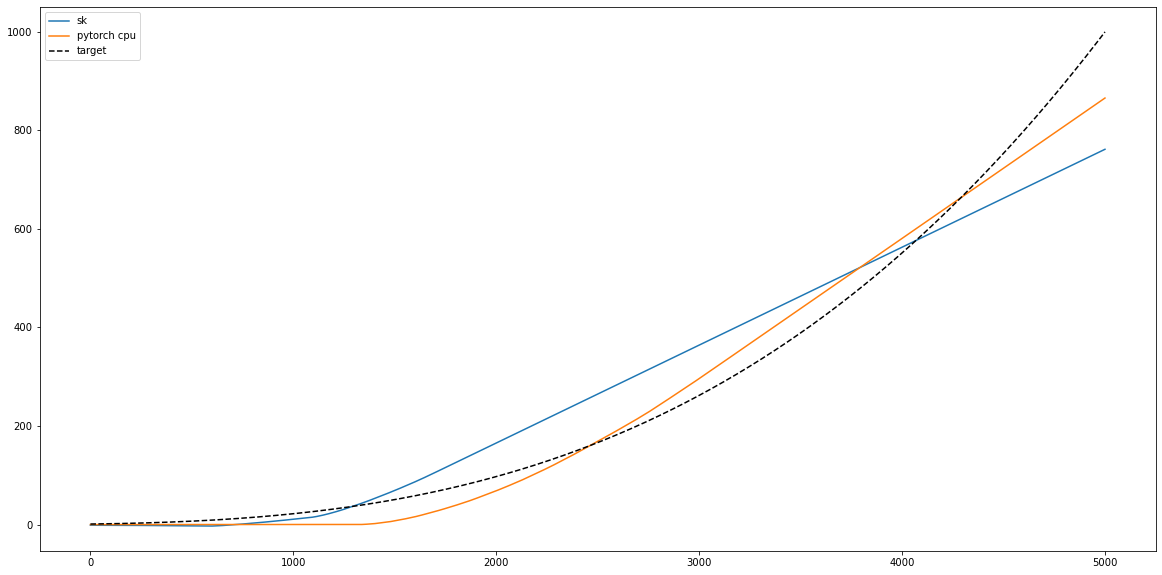

In [184]:
plt.figure(figsize=(20,10))
plt.plot(model_sklearn.predict(df_train[["x", "y"]]), label="sk")
plt.plot(model_pytorch_cpu(torch.Tensor(df_train[["x", "y"]].values).to(cpu_dev)).detach().cpu().numpy(), label="pytorch cpu")
#plt.plot(model_pytorch_gpu(torch.Tensor(df_train[["x", "y"]].values).to(gpu_dev)).detach().cpu().numpy(), label="pytorch gpu")
#plt.plot(out_pytorch_tpu, label="pytorch tpu")
plt.plot(df_train["target"],"k--",  label="target")
plt.legend()
plt.show()

In [52]:
model = MLPRegressor(
    hidden_layer_sizes=(l1_size,l2_size),
    random_state=1,
    verbose=False,
    max_iter=n_iter,
    tol=1e-10,
    learning_rate_init=learning_rate,
    batch_size=batch_size)

In [ ]:
model.fit(X=df_train[["x","y"]], y=df_train["target"])

MLPRegressor(batch_size=1, hidden_layer_sizes=(10, 5), learning_rate_init=0.01,
             max_iter=1000, random_state=1, tol=1e-10)

In [ ]:
model.predict(df_train[["x", "y"]])

array([-0.47960814, -0.47960814,  4.57565213, 16.40694518, 28.23823823,
       41.11501509, 55.0584445 , 69.00187391, 82.94530332, 96.88873273])

In [ ]:
# pytorch
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np


class Net2layers(nn.Module):
    def __init__(self, input_size, l1_size, l2_size):
        super(Net2layers, self).__init__()
        self.fc1 = nn.Linear(input_size, l1_size)
        self.fc2 = nn.Linear(l1_size, l2_size)
        self.fc3 = nn.Linear(l2_size, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
    def predict(self, df, feature_columns):
        m, n = df[feature_columns].shape
        x = torch.Tensor(df[feature_columns].values)
        output = self.forward(x)
        return output.detach().numpy()
    
def get_tensors(df, feature_columns, target_name, BS, device="cpu"):
    m, n = df[feature_columns].shape
    x_all = torch.Tensor(df[feature_columns].values).to(device)
    y_all = torch.Tensor(df[target_name].values).to(device)
    x = x_all.reshape([-1, BS, n] )
    y = y_all.reshape([-1, BS, 1] )
    return x, y
    

In [ ]:
model = Net2layers(input_size=input_size, l1_size = l1_size, l2_size=l2_size).to(device)
criterion = nn.MSELoss()
EPOCHS = n_iter
optm = Adam(model.parameters(), lr = learning_rate)

x, y = get_tensors(df_train,["x", "y"], "target", batch_size, device )
print(x.get_device())

for i in range(EPOCHS):
    
    optm.zero_grad()
    output = model(x)
    loss = criterion(output,y)
    loss.backward()
    optm.step()


-1


In [ ]:
model.predict(df_train, ["x", "y"])

array([[-0.5300847],
       [-0.5300847],
       [ 2.0356202],
       [15.027582 ],
       [28.019545 ],
       [41.011505 ],
       [54.003468 ],
       [66.99543  ],
       [79.9874   ],
       [92.97936  ]], dtype=float32)

In [ ]:
?model.predict()

Object `model.predict()` not found.


In [ ]:
df_train["target"]

0      1.0
1      4.0
2      9.0
3     16.0
4     25.0
5     36.0
6     49.0
7     64.0
8     81.0
9    100.0
Name: target, dtype: float64